# Features Engineering - Volatility

Volatility is a core concept in quantitative finance, reflecting the degree of price variation and market uncertainty. Accurately measuring and analyzing volatility is critical for risk management, strategy development, and position sizing. In this notebook, we will extract and engineer key **volatility-based features** using the `quantreo` package to better capture market dynamics and enhance model robustness.

⚠️ **Warning**: Volatility values depend on both the price scale and the timeframe you are analyzing. Higher timeframes or assets with larger price magnitudes can exhibit higher absolute volatility. Always normalize volatility when comparing across different assets or timeframes.

In [1]:
# Import the Features Engineering Package from Quantreo
import quantreo.features_engineering as fe

# To display the graphics
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
# Import a dataset to test the functions and create new ones easily
from quantreo.datasets import load_generated_ohlcv
df = load_generated_ohlcv()
df = df.loc["2016"]

# Show the data
df

,open,high,low,close,volume
time,,,,,
2016-01-04 00:00:00,104.944241,105.312073,104.929735,105.232289,576.805768
2016-01-04 04:00:00,105.233361,105.252139,105.047564,105.149357,485.696723
2016-01-04 08:00:00,105.159851,105.384745,105.141110,105.330306,403.969745
2016-01-04 12:00:00,105.330306,105.505799,104.894155,104.923404,1436.917324
2016-01-04 16:00:00,104.914147,105.023293,104.913252,105.014347,1177.672605
...,...,...,...,...,...
2016-12-30 04:00:00,103.632257,103.711884,103.495896,103.564574,563.932484
2016-12-30 08:00:00,103.564574,103.629321,103.555581,103.616731,697.707475
2016-12-30 12:00:00,103.615791,103.628165,103.496810,103.515847,1768.926665


<br>

## **CTC Volatility**

The `close_to_close_volatility` function calculates the **close-to-close volatility**, a widely used measure of market risk based on the standard deviation of **log returns**. This approach captures **price fluctuations over time** and is particularly useful in **statistical modeling and risk management**. The **close-to-close volatility** is defined as:

$$
\sigma_{CC} = \sqrt{\frac{1}{N - 1} \sum_{i=1}^{N} \left( \ln \frac{C_i}{C_{i-1}} - \mu \right)^2}
$$

Where:

- **$C_i$**: The **closing price** at time \(i\).
- **$N$**: The number of periods in the rolling window.
- **$\mu$**: The mean of the log returns over the window.

In [3]:
df["ctc_vol"] = fe.volatility.close_to_close_volatility(df=df, close_col="close", window_size=30)
df["ctc_vol"]

time
2016-01-04 00:00:00         NaN
2016-01-04 04:00:00         NaN
2016-01-04 08:00:00         NaN
2016-01-04 12:00:00         NaN
2016-01-04 16:00:00         NaN
                         ...   
2016-12-30 04:00:00    0.002443
2016-12-30 08:00:00    0.002438
2016-12-30 12:00:00    0.002413
2016-12-30 16:00:00    0.002286
2016-12-30 20:00:00    0.002259
Name: ctc_vol, Length: 1548, dtype: float64

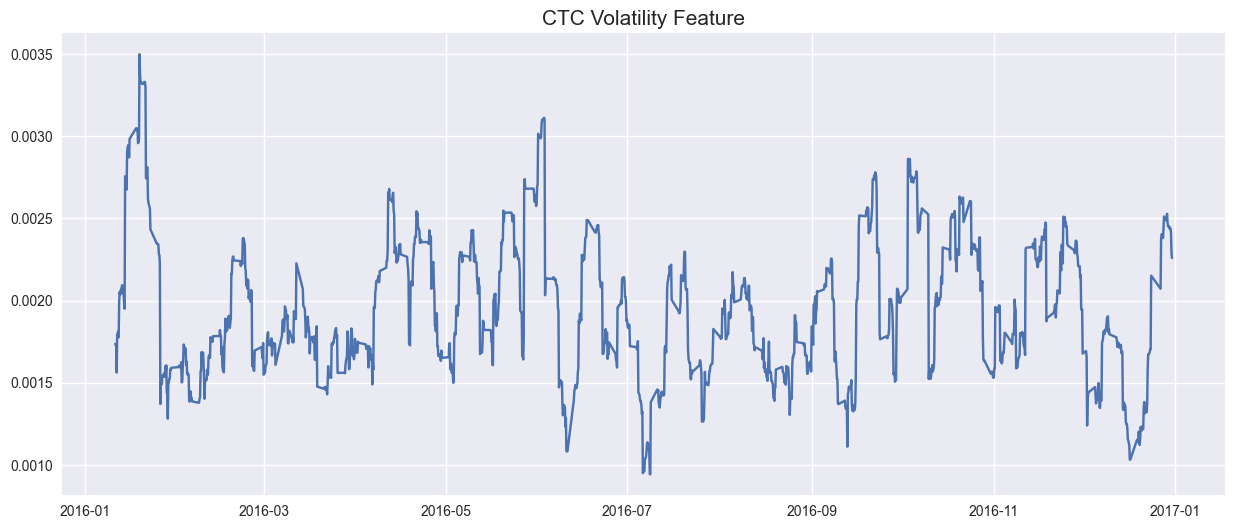

In [4]:
plt.figure(figsize=(15,6))
plt.plot(df["ctc_vol"])
plt.title("CTC Volatility Feature", size=15)
plt.show()

<br>

## **Parkinson Volatility**

The `parkinson_volatility` function computes the **Parkinson volatility**, an estimator designed to measure market volatility using only **high and low prices**. This approach provides a more accurate estimate than simple **close-to-close volatility**, particularly in **markets with low closing price variation but significant intraday movement**.

The **Parkinson estimator** is defined as:

$$
\sigma_P^2 = \frac{1}{4N \ln(2)} \sum_{i=1}^{N} \left( \ln \frac{h_i}{l_i} \right)^2
$$

Where:

- **$h_i$**: The **high price** at time $i$.
- **$l_i$**: The **low price** at time $i$.
- **$N$**: The number of periods in the rolling window.

In [5]:
df["parkinson_vol"] = fe.volatility.parkinson_volatility(df=df, high_col="high", low_col="low", window_size=30)
df["parkinson_vol"]

time
2016-01-04 00:00:00         NaN
2016-01-04 04:00:00         NaN
2016-01-04 08:00:00         NaN
2016-01-04 12:00:00         NaN
2016-01-04 16:00:00         NaN
                         ...   
2016-12-30 04:00:00    0.002410
2016-12-30 08:00:00    0.002359
2016-12-30 12:00:00    0.002357
2016-12-30 16:00:00    0.002335
2016-12-30 20:00:00    0.002222
Name: parkinson_vol, Length: 1548, dtype: float64

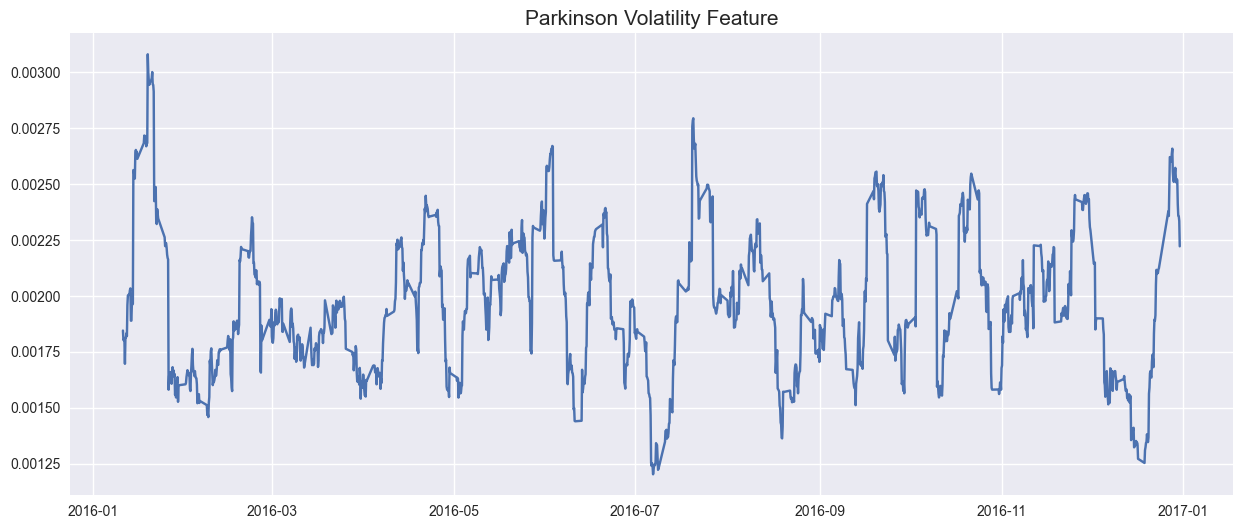

In [6]:
plt.figure(figsize=(15,6))
plt.plot(df["parkinson_vol"])
plt.title("Parkinson Volatility Feature", size=15)
plt.show()

<br>

## **Rogers-Satchell Volatility**
The `rogers_satchell_volatility` function computes the **Rogers-Satchell volatility**, an estimator designed specifically for **assets with a directional drift**, making it more suitable for financial markets than standard measures like **close-to-close volatility**.

The **Rogers-Satchell estimator** is defined as:

$$
\sigma_{RS}^2 = \frac{1}{N} \sum_{i=1}^{N} \left( \ln (\frac{h_i}{c_i}) \ln (\frac{h_i}{o_i}) + \ln (\frac{l_i}{c_i}) \ln (\frac{l_i}{o_i}) \right)
$$

Where:

- **$h_i$**: The **high price** at time $i$.
- **$l_i$**: The **low price** at time $i$.
- **$o_i$**: The **open price** at time $i$.
- **$c_i$**: The **close price** at time $i$.
- **$N$**: The number of periods in the rolling window.

In [7]:
df["rs_vol"] = fe.volatility.rogers_satchell_volatility(df=df, high_col="high", low_col="low", open_col="open", close_col="close", window_size=30)
df["rs_vol"]

time
2016-01-04 00:00:00         NaN
2016-01-04 04:00:00         NaN
2016-01-04 08:00:00         NaN
2016-01-04 12:00:00         NaN
2016-01-04 16:00:00         NaN
                         ...   
2016-12-30 04:00:00    0.002434
2016-12-30 08:00:00    0.002328
2016-12-30 12:00:00    0.002326
2016-12-30 16:00:00    0.002307
2016-12-30 20:00:00    0.002227
Name: rs_vol, Length: 1548, dtype: float64

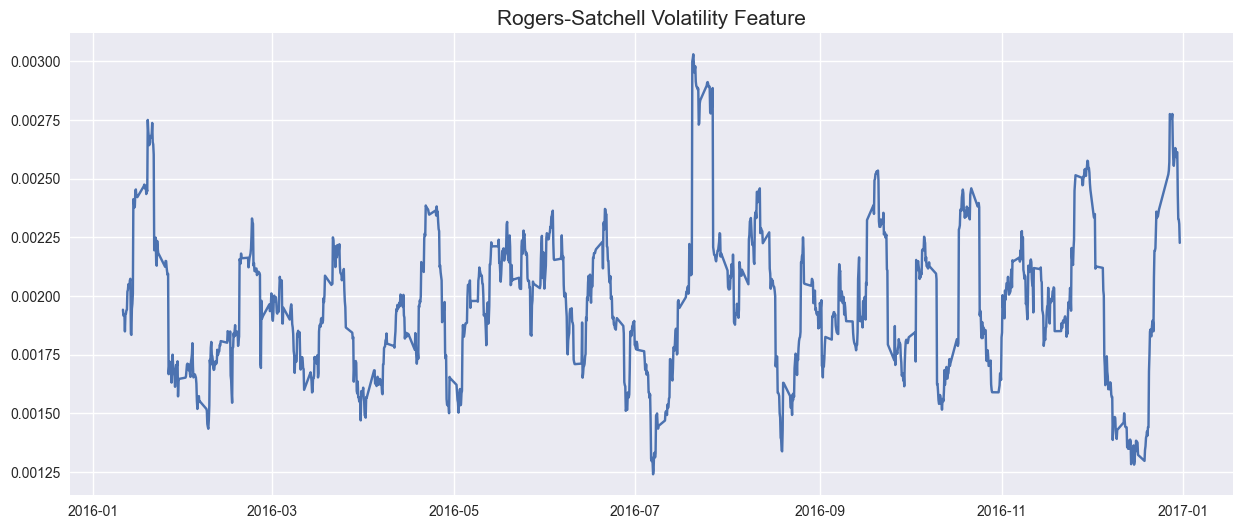

In [8]:
plt.figure(figsize=(15,6))
plt.plot(df["rs_vol"])
plt.title("Rogers-Satchell Volatility Feature", size=15)
plt.show()

<br>

## **Yang-Zhang Volatility Estimator**

The `yang_zhang_volatility` function computes the **Yang-Zhang volatility**, an advanced estimator that integrates **overnight, close-to-close, and intra-day price movements**. This method is particularly useful for assets with **significant overnight gaps**, making it more robust than traditional measures.

The **Yang-Zhang estimator** is defined as:

$$
\sigma_t = \sqrt{\sigma_O^2 + k\sigma_C^2 + (1 - k) \sigma_{RS}^2}
$$


Where:

- **$\sigma_O^2$**: The **overnight volatility**, measuring the variance between **close-to-open** prices.
- **$\sigma_C^2$**: The **close-to-close volatility**, capturing daily price changes.
- **$\sigma_{RS}^2$**: The **Rogers-Satchell estimator**, which accounts for intra-day price movements.
- **$k$**: A weighting factor empirically determined by Yang & Zhang, according to them, the best empirical value is 0.34.


In [9]:
df["yz_vol"] = fe.volatility.yang_zhang_volatility(df=df, low_col="low",high_col="high", open_col="open", close_col="close", window_size=30)
df["yz_vol"]

time
2016-01-04 00:00:00         NaN
2016-01-04 04:00:00         NaN
2016-01-04 08:00:00         NaN
2016-01-04 12:00:00         NaN
2016-01-04 16:00:00         NaN
                         ...   
2016-12-30 04:00:00    0.003399
2016-12-30 08:00:00    0.003350
2016-12-30 12:00:00    0.003347
2016-12-30 16:00:00    0.003318
2016-12-30 20:00:00    0.003149
Name: yz_vol, Length: 1548, dtype: float64

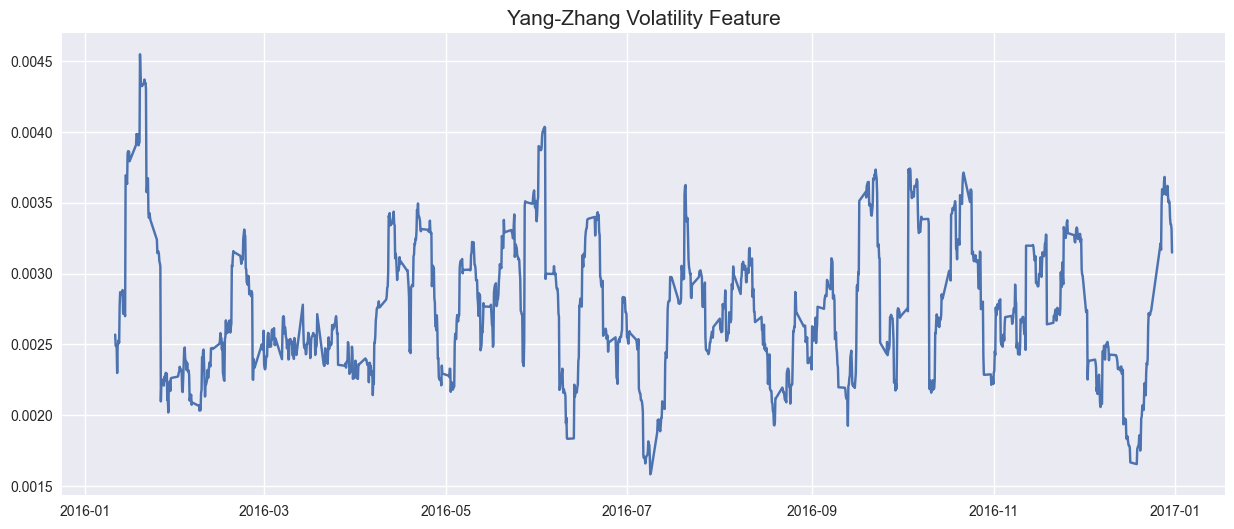

In [10]:
plt.figure(figsize=(15,6))
plt.plot(df["yz_vol"])
plt.title("Yang-Zhang Volatility Feature", size=15)
plt.show()

<br>

## Compare the volatilities

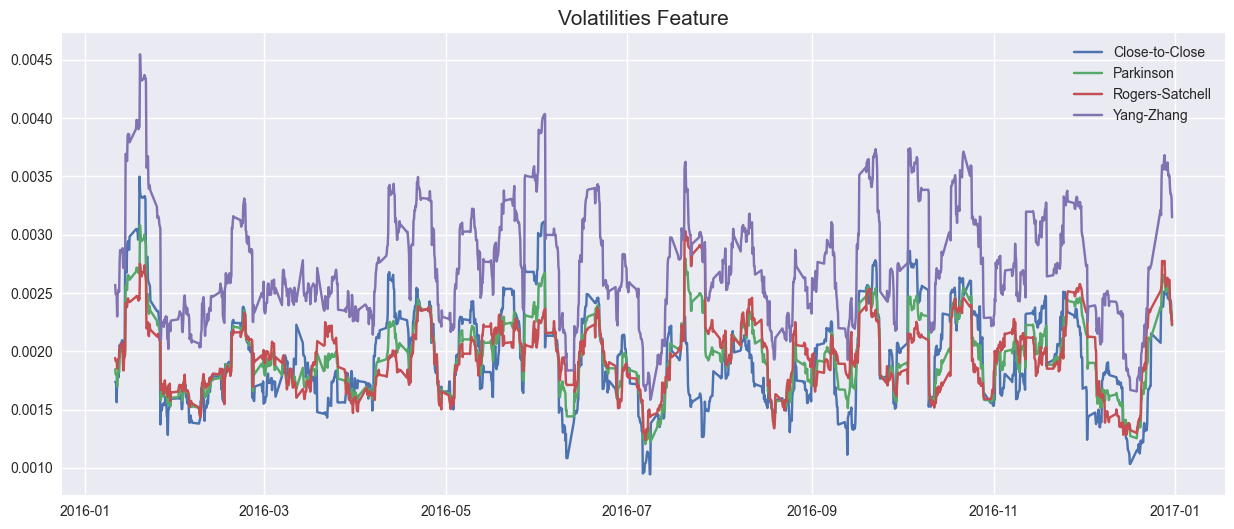

In [11]:
plt.figure(figsize=(15,6))
plt.plot(df["ctc_vol"], label="Close-to-Close")
plt.plot(df["parkinson_vol"], label="Parkinson")
plt.plot(df["rs_vol"], label="Rogers-Satchell")
plt.plot(df["yz_vol"], label="Yang-Zhang")
plt.title("Volatilities Feature", size=15)
plt.legend()
plt.show()

In [12]:
df[["ctc_vol", "parkinson_vol", "rs_vol", "yz_vol"]].corr()

,ctc_vol,parkinson_vol,rs_vol,yz_vol
ctc_vol,1.000000,0.824998,0.546899,0.926389
parkinson_vol,0.824998,1.000000,0.906328,0.963295
rs_vol,0.546899,0.906328,1.000000,0.767437
yz_vol,0.926389,0.963295,0.767437,1.000000
